In [8]:
import cv2
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import glob
import os.path as op

In [14]:
def imshow(img, cmap=None):
    plt.imshow(img, cmap)
    plt.show()

In [15]:
def load_data(data_path, data_ext):
    images = []
    for filename in sorted(glob.glob(op.join(data_path, '*.'+data_ext))):
        print(filename)
        
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        
        imshow(img)
    
    return np.array(images)

images/parrington/prtn00.jpg


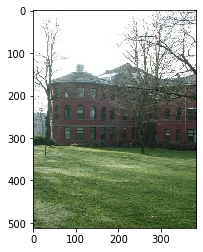

images/parrington/prtn01.jpg


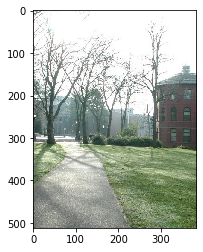

images/parrington/prtn02.jpg


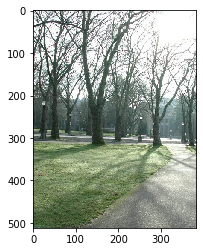

images/parrington/prtn03.jpg


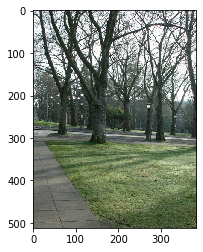

images/parrington/prtn04.jpg


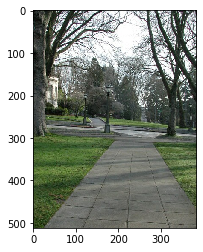

images/parrington/prtn05.jpg


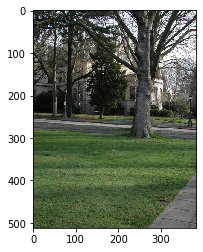

images/parrington/prtn06.jpg


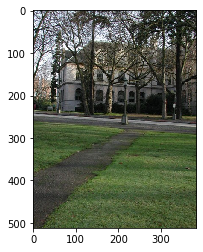

images/parrington/prtn07.jpg


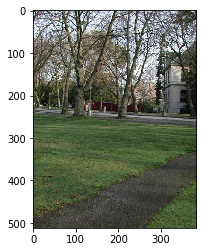

images/parrington/prtn08.jpg


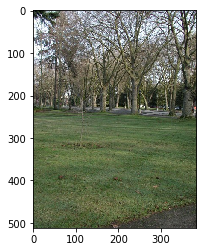

images/parrington/prtn09.jpg


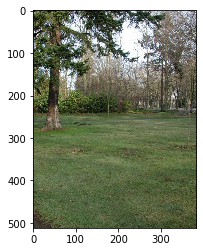

images/parrington/prtn10.jpg


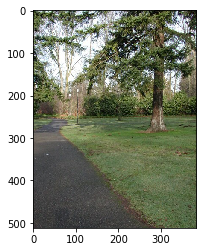

images/parrington/prtn11.jpg


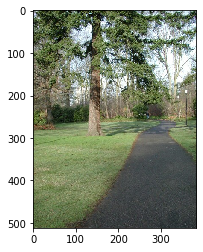

images/parrington/prtn12.jpg


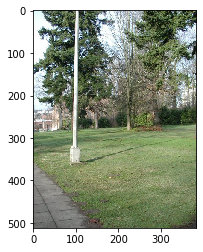

images/parrington/prtn13.jpg


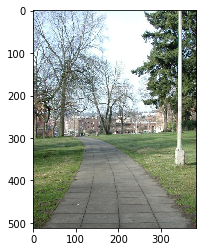

images/parrington/prtn14.jpg


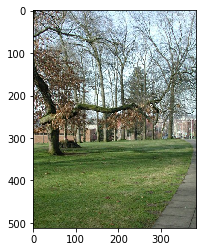

images/parrington/prtn15.jpg


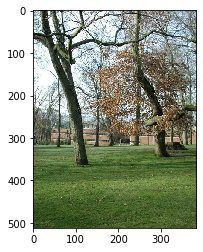

images/parrington/prtn16.jpg


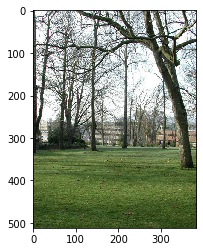

images/parrington/prtn17.jpg


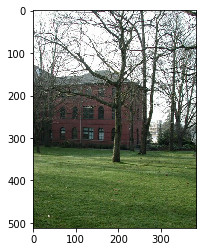

(18, 512, 384, 3)


In [16]:
img_set = load_data('images/parrington', 'jpg')
print(img_set.shape)

In [148]:
def smoothedGrasient(I, ks, sig):
    # gradient (h, w, c)
    # padding: mirror (h+2, w+2, c)
    I_p = cv2.copyMakeBorder(I, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    # filter: [-1, 0, 1] (h, w, c)
    g_x = (I_p[2:, 1:-1] - I_p[:-2, 1:-1]) / 2
    g_y = (I_p[1:-1, 2:] - I_p[1:-1, :-2]) / 2
    
    # blurred gradient (h, w, c)
    I_x = cv2.GaussianBlur(g_x, ks, sig)
    I_y = cv2.GaussianBlur(g_y, ks, sig)
    
    return I_x, I_y


def localMaximum(I, threshold, ks=(3, 3)):
    # get coords of value greater then threshold
    coords = np.argwhere(I > threshold)
    print(coords.shape)
    
    # padding: mirror (h+2, w+2, c)
    I_p = cv2.copyMakeBorder(I, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    
    # collect local-maxima
    local_maxima = []
    for coord in coords:
        # plus 1 for padding
        x, y = coord + 1
        
        if np.all(I_p[x, y] - I_p[x-1:x+2, y-1:y+2] >= 0):
            local_maxima.append(coord)
                                
    return np.array(local_maxima)
    
def subPixelRefinement(I, coords):
    
    # padding: mirror (h+2, w+2, c)
    I_p = cv2.copyMakeBorder(I, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    
    sp_coords = []
    values = []
    for coord in coords:
        # plus 1 for padding
        x, y = coord + 1
        
        # 1st order derivative (gradient)
        g = np.array([[I_p[x+1, y] - I_p[x-1, y]], [I_p[x, y+1] - I_p[x, y-1]]]) / 2
        # 2nd order derivative (Hassian matrix)
        h_a = I_p[x-1, y] - 2*I_p[x, y] + I_p[x+1, y]
        h_b = I_p[x, y-1] - 2*I_p[x, y] + I_p[x, y+1]
        h_c = (I_p[x-1, y-1] - I_p[x-1, y+1] - I_p[x+1, y-1] + I_p[x+1, y+1]) / 4
        H = np.array([[h_a, h_c], [h_c, h_b]])
        
        # accurate maximum location
        dcoord_m = -np.matmul(la.inv(H), g)
        
        # TODO: change sampled pixel
        #if np.abs(dcoord_m[0, 0]) > 0.5:
        #    print('change x', dcoord_m[0, 0])
        #if np.abs(dcoord_m[1, 0]) > 0.5:
        #    print('change y', dcoord_m[1, 0])
        
        # maximum
        value = I_p[x, y] + 1/2 * np.matmul(g.transpose(), dcoord_m)
        
        # collect result
        sp_coords.append(coord + np.reshape(dcoord_m, 2))
        values.append(value[0, 0])

    return np.array(sp_coords), np.array(values)
    

# TODO: Adaptive Non-Maximum Suppression
def ANMS(img, nums):
    pass


# determinant and trace of Harris Matrix
def Harris(I, ks=(5, 5), sig_i=1.5, sig_d=1.0):
    # convert to float (0 ~ 1)
    I_f = I.astype(np.float32) / 255.0
    
    # smoothed gradient (h, w, c)
    I_x, I_y = smoothedGrasient(I_f, ks, sig_d)
    #imshow(I_x)
    #imshow(I_y)
    
    # (h, w, c)
    S_x2 = cv2.GaussianBlur(I_x * I_x, ks, sig_i)
    S_y2 = cv2.GaussianBlur(I_y * I_y, ks, sig_i)
    S_xy = cv2.GaussianBlur(I_x * I_y, ks, sig_i)
    #imshow(S_x2)
    #imshow(S_y2)
    #imshow(S_xy)
    
    # Harris Matrix (h, w, 2, 2, c)
    #H_l = np.moveaxis([[S_x2, S_xy], [S_xy, S_y2]], (0, 1), (2, 3))
    
    # determinant and trace (h, w, c)
    #det_H = H_l[:, :, 0, 0]*H_l[:, :, 1, 1] - H_l[:, :, 1, 0]*H_l[:, :, 0, 1]
    #tr_H = np.trace(H_l, axis1=2, axis2=3)
    det_H = S_x2 * S_y2 - S_xy * S_xy
    tr_H = S_x2 + S_y2
    #imshow(det_H)
    #imshow(tr_H)
    
    return det_H, tr_H

def HarrisCornerDetector(img, k=0.05, th=1):
    '''
    Arguments:
        img: gray-scale image, 0~255
    '''
    
    # Harris (h, w, c)
    det_H, tr_H = Harris(img)
    
    # response (h, w, c)
    R = det_H - k*np.power(tr_H, 2)
    #imshow(R)
    #print(np.max(R), np.min(R))
    
    # thresholding & find local-maxima
    threshold = 0.01 * R.max()
    local_maxima = localMaximum(R, threshold)
    
    # non-maximum suppression
    #ANMS()
    
    # sub-pixel refinement
    key_points, _ = subPixelRefinement(R, local_maxima)
    
    return key_points, local_maxima
    
def simpleDescriptor(I, key_points):
    '''
    Arguments:
        img: gray-scale image, 0~255
    '''
    # convert to float (0 ~ 1)
    I_f = I.astype(np.float32) / 255.0
    h, w = I_f.shape
    
    # FIXME: the padding is to prevent accessing pixels out of image
    # however, this is not good since this may cause mismatch
    # the better way is to remove such key point
    # padding: mirror (h+2, w+2, c)
    #I_p = cv2.copyMakeBorder(I, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    
    # compute descriptor
    descriptors = []
    new_keypoints = []
    for kp in key_points:
        x = int(round(kp[0]))
        y = int(round(kp[1]))
        
        # skip key point accessing invalid pixel
        if x < 1 or x > h-2 or y < 1 or y > w-2:
            continue
        
        # take 9x9 as descriptor
        des = np.reshape(I_f[x-1:x+2, y-1:y+2], 9)
        
        descriptors.append(des)
        new_keypoints.append(kp)
        
    return np.array(new_keypoints), np.array(descriptors)
    
    

def MSOPDescriptor(I, key_points, ks=(5, 5), sig_p=1.0, sig_o=4.5):
    '''
    Arguments:
        img: gray-scale image, 0~255
    '''
    # convert to float (0 ~ 1)
    I_f = I.astype(np.float32) / 255.0
    h, w = I_f.shape
    
    # smoothed gradient (h, w, c)
    I_x, I_y = smoothedGrasient(I_f, ks, sig_o)
    #print(I_y.shape)
    
    # major orientation (h, w, c)
    u_mag = la.norm([I_x, I_y], axis=0)
    #imshow(u_mag)
    cos_theta = I_x / u_mag
    sin_theta = I_y / u_mag
    #imshow(cos_theta)
    #imshow(sin_theta)
    
    # blur image (h, w, c)
    I_b = cv2.GaussianBlur(I_f, ks, 2*sig_p)
    #print(I_b.shape)
    
    # compute descriptor
    descriptors = []
    new_keypoints = []
    for kp in key_points:
        # major orientation of the key point
        # FIXME: what coord to use to get orientation?
        mo_cos = cos_theta[int(round(kp[0])), int(round(kp[1]))]
        mo_sin = sin_theta[int(round(kp[0])), int(round(kp[1]))]
        
        # sample 8x8 pixels
        des = []
        isInvalid = False
        for i in range(-4, 4):
            for j in range(-4, 4):
                # sample point coordinate
                x = kp[0] + 5*(i+0.5) * mo_cos
                y = kp[1] + 5*(j+0.5) * mo_sin
                
                # bilinear interpolation
                r_x = int(x)
                r_y = int(y)
                
                # skip key point accessing invalid pixel 
                isInvalid = r_x < 0 or r_x > h-2 or r_y < 0 or r_y > w-2
                if isInvalid:
                    break
                
                dx = x - r_x
                dy = y - r_y
                value = np.matmul(np.matmul([1-dx, dx], I_b[r_x:r_x+2, r_y:r_y+2]), [[1-dy], [dy]])
                        
                des.append(value[0])
            
            # skip key point accessing invalid pixel 
            if isInvalid:
                break
                
        # skip key point accessing invalid pixel 
        if isInvalid:
            continue
                
        # normalization
        des = (des - np.mean(des)) / np.std(des)
        #imshow(np.reshape(des, (8, 8)))
        
        # TODO: wavelet transform
        
        descriptors.append(des)
        new_keypoints.append(kp)
        
    return np.array(new_keypoints), np.array(descriptors)

# Multi-Scale Oriented Patches
def MSOP(img, ks=(5, 5), sig_p=1.0, sig_i=1.5, sig_d=1.0, th=10.0):
    '''
    Arguments:
        img: gray-scale image, 0~255
    '''
    
    # Multi-Scale Harris Corner Detector
    P = []
    f_HM = []
    
    P_l = img
    for i in range(3):
        # add layer to pyramid
        P.append(P_l)
        # compute Harris
        det_H, tr_H = Harris(P[-1])
        # corner detection function
        # FIXME: deal with tr_H=0
        f_HM.append(det_H / tr_H)
        print('f_HM')
        imshow(f_HM[-1])
        
        # local-maxima
        local_maxima = localMaximum(f_HM[-1], th)
        
        # non-maximum suppression
        #ANMS(f_HM[-1])
        
        # sub-pixel refinement
        keypoints, _ = subPixelRefinement(f_HM[-1], local_maxima)
        
        # next layer
        # gaussian blur
        P_l = cv2.GaussianBlur(P[i], ks, sig_p)
        # down sampling
        P_l = P_l[::2, ::2]


In [39]:
def HarrisLib(img):
    img_gray = cv2.cvtColor(img_set[0], cv2.COLOR_RGB2GRAY)
    dst = cv2.cornerHarris(img_gray, 5, 3, 0.05)
    print(dst.max(), dst.min())
    imshow(dst)
    
    dst = cv2.dilate(dst, None)
    
    img_c = np.copy(img)
    
    img_c[dst>0.01*dst.max()] = [255, 0, 0]
    
    imshow(img_c)
    
    return dst
    
    

In [83]:
def drawPoints(img, coords, coords2=None, color=[255, 0, 0], color2=[0, 0, 255]):
    img_c = np.copy(img)
    
    if coords2 is not None:
        for x, y in coords2:
            cv2.circle(img_c, (int(round(y)), int(round(x))), 2, color2, -1)
    
    for x, y in coords:
        cv2.circle(img_c, (int(round(y)), int(round(x))), 2, color, -1)

    imshow(img_c)
    

In [41]:
img_gray = []
for img in img_set:
    img_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    
img_gray = np.array(img_gray)

(10684, 2)
(545, 2)


<ipython-input-148-a5eed2d016f6>:187: RuntimeWarning: invalid value encountered in true_divide
  cos_theta = I_x / u_mag
<ipython-input-148-a5eed2d016f6>:188: RuntimeWarning: invalid value encountered in true_divide
  sin_theta = I_y / u_mag


(499, 2)
(499, 64)


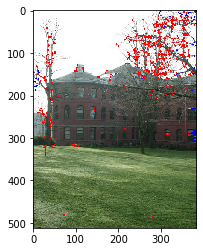

(11308, 2)
(672, 2)
(624, 2)
(624, 64)


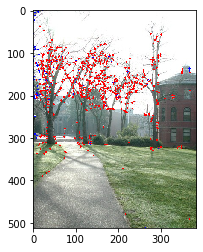

(22459, 2)
(1152, 2)
(1021, 2)
(1021, 64)


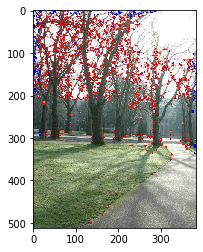

(24321, 2)
(1215, 2)
(1083, 2)
(1083, 64)


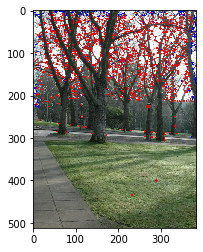

(14321, 2)
(826, 2)
(724, 2)
(724, 64)


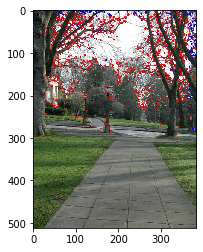

(16678, 2)
(809, 2)
(698, 2)
(698, 64)


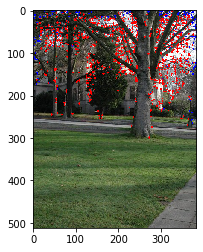

(20535, 2)
(931, 2)
(802, 2)
(802, 64)


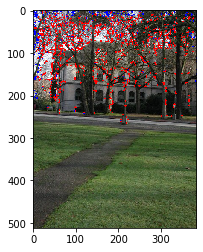

(21176, 2)
(1055, 2)
(934, 2)
(934, 64)


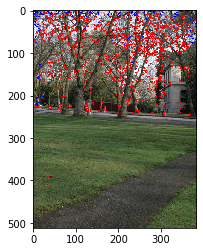

(20170, 2)
(995, 2)
(875, 2)
(875, 64)


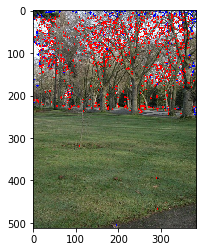

(20343, 2)
(896, 2)
(765, 2)
(765, 64)


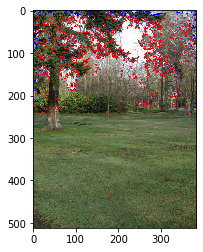

(27502, 2)
(1193, 2)
(1041, 2)
(1041, 64)


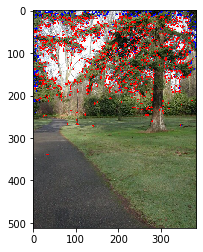

(25311, 2)
(1285, 2)
(1155, 2)
(1155, 64)


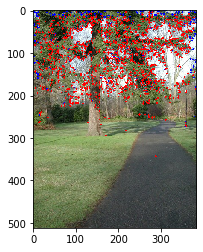

(18420, 2)
(1037, 2)
(932, 2)
(932, 64)


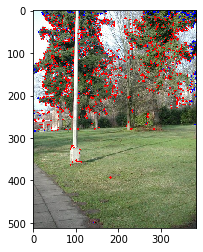

(18723, 2)
(1047, 2)
(959, 2)
(959, 64)


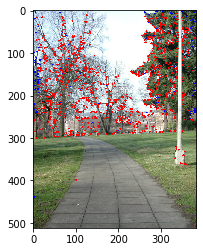

(35442, 2)
(1675, 2)
(1528, 2)
(1528, 64)


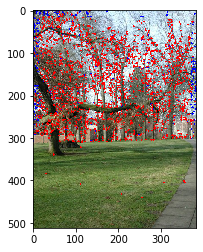

(17410, 2)
(1111, 2)
(1020, 2)
(1020, 64)


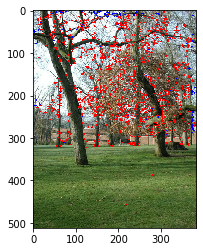

(21627, 2)
(1252, 2)
(1139, 2)
(1139, 64)


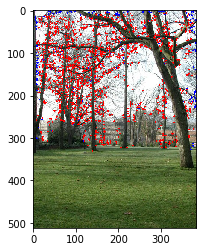

(26733, 2)
(1265, 2)
(1109, 2)
(1109, 64)


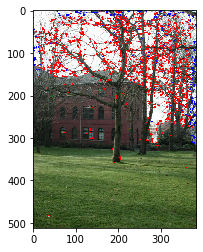

In [150]:
for i in range(len(img_set)):
    # Harris corner detector
    key_points, local_maxima = HarrisCornerDetector(img_gray[i])
    print(key_points.shape)
    
    # naive descriptor
    #key_points, descriptors = simpleDescriptor(img_gray[i], key_points)
    
    # MSOP descriptor
    key_points, descriptors = MSOPDescriptor(img_gray[i], key_points)
    
    print(key_points.shape)
    print(descriptors.shape)
    
    drawPoints(img_set[i], key_points, local_maxima)

#_ = HarrisLib(img_set[0])

f_HM


<ipython-input-67-aac17b4de33c>:170: RuntimeWarning: invalid value encountered in true_divide
  f_HM.append(det_H / tr_H)


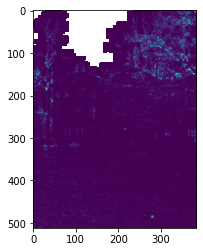

<ipython-input-67-aac17b4de33c>:3: RuntimeWarning: invalid value encountered in greater
  coords = np.argwhere(I > threshold)


(0, 2)
f_HM


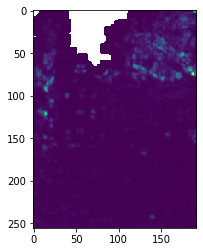

(0, 2)
f_HM


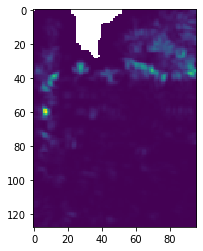

(0, 2)


In [68]:
MSOP(img_gray[0])